# Covid 19 detection from X ray Data

## Importing Libaries

In [23]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import matplotlib.image as mpimg
import tensorflow as tf
from keras import backend
from PIL import Image
from skimage import io, color, transform
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam, SGD, RMSprop
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,recall_score,accuracy_score,precision_score
from sklearn.metrics import roc_auc_score,roc_curve,auc

import warnings
warnings.filterwarnings('ignore')

## importing dataset

In [2]:
#data loading
data = 'CovidXRayImages/Val'
data

'CovidXRayImages/Val'

## Loading the images into an array, change the image size and converting it into grayscale

In [3]:
#defining the image size
img_size = 128

# loading a dataset into list
covid_img=[]
covid_lbl=[]
for img_path in glob.glob(data+'/COVID-19/images/*'):
    #reading the images
    img =cv2.imread(img_path)
    #converting into grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #resizing the image
#     gray_img = transform.resize(gray_img, (img_size, img_size))
    #scalling the images
#     gray_img = gray_img / 255.0
#     gray_img = gray_img.astype(np.uint8)
    #appending images into list
    covid_img.append(gray_img)
    #adding labels
    covid_lbl.append(0)

non_covid_img=[]
non_covid_lbl=[]
for img_path in glob.glob(data+'/Non-COVID/images/*'):
    #reading the images
    img =cv2.imread(img_path)
     #converting into grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #resizing the image
#     gray_img = transform.resize(gray_img, (img_size, img_size))
     #scalling the images
#     gray_img = gray_img / 255.0
#     gray_img = gray_img.astype(np.uint8)
    #appending images into list
    non_covid_img.append(gray_img)
    #adding labels
    non_covid_lbl.append(1)

    
normal_img=[]
normal_lbl=[]
for img_path in glob.glob(data+'/Normal/images/*'):
    #reading the images
    img =cv2.imread(img_path)
    #converting into grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #resizing the image
#     gray_img = transform.resize(gray_img, (img_size, img_size))
     #scalling the images
#     gray_img = gray_img / 255.0
#     gray_img = gray_img.astype(np.uint8)
    #appending images into list
    normal_img.append(gray_img)
    #adding labels
    normal_lbl.append(2)

    
#checking the length of each list
print("length of the covid images: ",len(covid_img))
print("length of the non covid image: ",len(non_covid_img))
print("length of the normal image: ",len(normal_img))

length of the covid images:  1903
length of the non covid image:  1802
length of the normal image:  1712


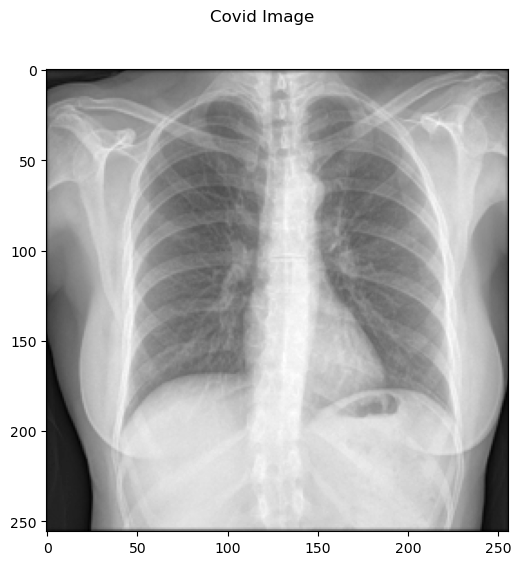

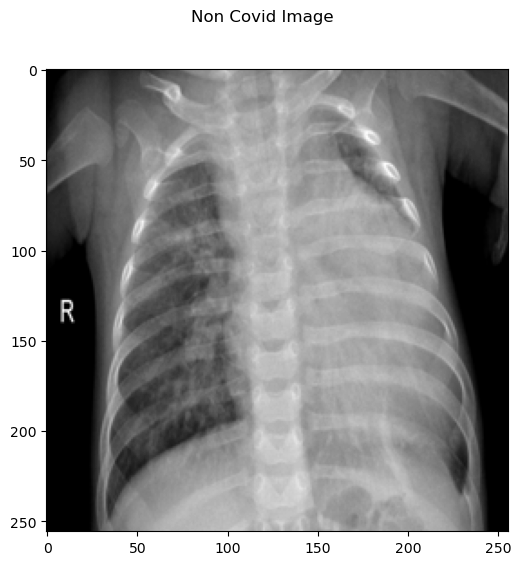

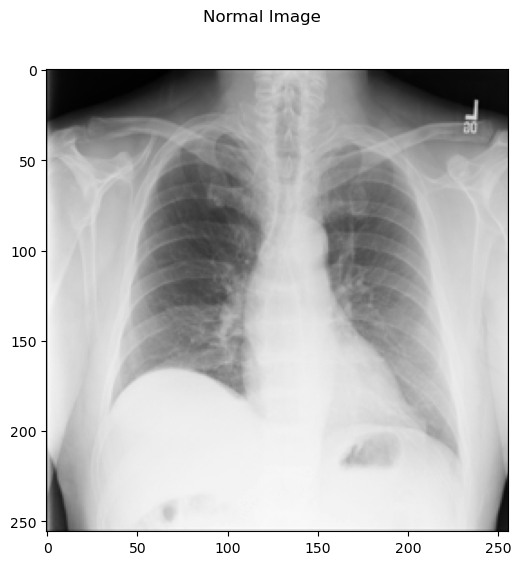

In [5]:
#plotting the images to check how the data is
fig = plt.figure()
fig.suptitle('Covid Image')
plt.imshow(covid_img[0], cmap='gray')

fig = plt.figure()
fig.suptitle('Non Covid Image')
plt.imshow(non_covid_img[0], cmap='gray')

fig = plt.figure()
fig.suptitle('Normal Image')
plt.imshow(normal_img[0], cmap='gray')

In [6]:
#checking the type of the images
print("Covid image type: ",covid_img[0].dtype)
print("Non Covid image type: ",non_covid_img[0].dtype)
print("Normal image type: ",normal_img[0].dtype)

Covid image type:  uint8
Non Covid image type:  uint8
Normal image type:  uint8


In [7]:
#printing the shape of images
print(covid_img[0].shape)
print(non_covid_img[0].shape)
print(normal_img[0].shape)

(256, 256)
(256, 256)
(256, 256)


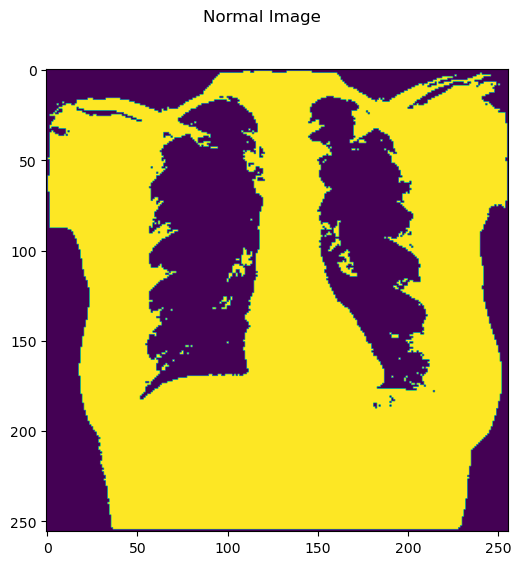

In [8]:
#performing the intensity threshold
def int_thres(image, th_value):
    _,th_image=cv2.threshold(image, th_value, 255, cv2.THRESH_BINARY)
    return th_image

#defining the threshold value
th_value = 140

#applying intensity threshold to each images
r_covid = [int_thres(image, th_value) for image in covid_img]
r_non_c = [int_thres(image, th_value) for image in non_covid_img]
r_normal = [int_thres(image, th_value) for image in normal_img]

fig = plt.figure()
fig.suptitle('Normal Image')
plt.imshow(r_covid[0])

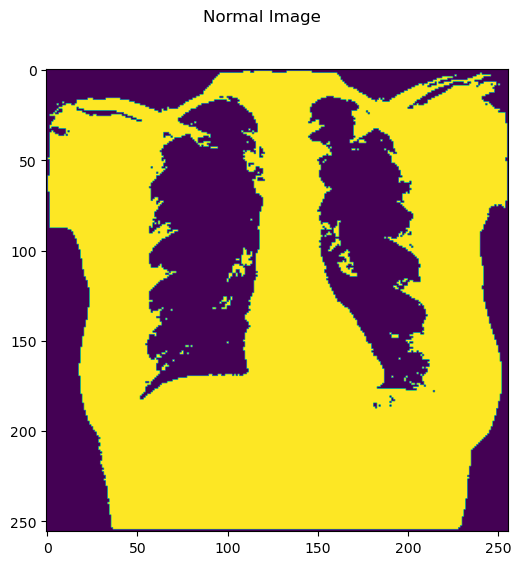

In [9]:
#performing historical equilization
def hist_eque(image):
    eque_img = cv2.equalizeHist(image)
    return eque_img

#applying histogram equilization to each images
r_covid = [hist_eque(i) for i in r_covid]
r_non_c = [hist_eque(i) for i in r_non_c]
r_normal = [hist_eque(i) for i in r_normal]

fig = plt.figure()
fig.suptitle('Normal Image')
plt.imshow(r_covid[0])

In [10]:
#combining all data and labels
data = []
labels = []

for class_images, class_labels in [(covid_img, covid_lbl), (non_covid_img, non_covid_lbl), (normal_img, normal_lbl)]:
    data.extend(class_images)
    labels.extend(class_labels)

#converting the lists to numpy
data = np.array(data)
labels = np.array(labels)

In [11]:
#printing the label size and data
print(len(data))
print(len(labels))
print(data)
print(labels)
print(data[0].shape)
print(labels[0].shape)

5417
5417
[[[ 28  29  31 ...  53  47  43]
  [ 39  46  46 ... 100  89  63]
  [ 42  53  55 ... 113 107  80]
  ...
  [ 33  42  45 ...  47  42  34]
  [ 33  40  43 ...  46  41  36]
  [ 26  31  33 ...  34  31  30]]

 [[  4   4   4 ...   0   0   0]
  [  5   5   5 ...   1   1   1]
  [  5   5   5 ...   1   1   1]
  ...
  [ 42  42  43 ...   1   1   1]
  [  0   0   0 ...   1   1   1]
  [  0   0   0 ...   0   0   0]]

 [[ 81  31  19 ...  12  22  59]
  [ 78  29  18 ...  11  21  58]
  [ 78  29  18 ...  11  20  58]
  ...
  [ 42   1   1 ... 174 169  86]
  [ 42   2   1 ... 119 126  84]
  [ 41   1   2 ...  10  24  75]]

 ...

 [[239 236 237 ... 248 253 219]
  [231 231 231 ... 247 251 218]
  [226 226 225 ... 247 250 218]
  ...
  [ 32  33  33 ...  99 148 178]
  [ 38  37  37 ... 102 150 180]
  [ 44  43  43 ... 102 152 182]]

 [[  1   1   1 ...   1   1   1]
  [  1   1   1 ...   1   1   1]
  [  1   1   1 ...   1   1   1]
  ...
  [ 20  21  20 ...  23  24  22]
  [ 22  22  21 ...  23  25  25]
  [ 20  20  19 ...

## Performing Train Test Split

In [12]:
#train test split
train_data, validation_data, train_labels, validation_labels = train_test_split(data, labels, test_size=0.3, random_state=42)

In [13]:
# # Encoding labels
# label_encoder = LabelEncoder()
# train_labels = label_encoder.fit_transform(train_labels)
# validation_labels = label_encoder.transform(validation_labels)

In [14]:
#defininh image size, channels, batch size, epoches and number of classes
img_h = 256
img_w = 256
channels =1
input_shape = (img_h, img_w, channels)

n_classes = 3
epochs = 10
batch_size = 35

## CNN Model

In [15]:
model_0 =Sequential()

#adding convolution layer
model_0.add(Conv2D(32,(3,3), activation= 'relu', input_shape=(256,256,1)))
model_0.add(MaxPooling2D(pool_size=(2, 2)))
model_0.add(Conv2D(64,(3,3), activation='relu'))
model_0.add(MaxPooling2D(pool_size=(2,2)))
model_0.add(Conv2D(128,(3,3), activation='relu'))
model_0.add(MaxPooling2D(pool_size=(2,2)))

#flattening the images and performing dropouts
model_0.add(Flatten())
model_0.add(Dropout(0.30))

#adding a dense layer
model_0.add(Dense(128, activation='relu'))
model_0.add(Dropout(0.20))

#adding an output layer
model_0.add(Dense(3, activation='softmax'))

In [16]:
#printing summary of a model
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

In [17]:
#model compiling
model_0.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(train_data.shape)
print(train_labels.shape)
print(validation_data.shape)
print(validation_labels.shape)


(3791, 256, 256)
(3791,)
(1626, 256, 256)
(1626,)


In [18]:
#training the model
history = model_0.fit(
    train_data,
    train_labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(validation_data, validation_labels)
)

Epoch 1/10


109/109 [==============================] - 99s 902ms/step - loss: 6.9114 - accuracy: 0.6043 - val_loss: 0.8156 - val_accuracy: 0.7060
Epoch 2/10
109/109 [==============================] - 98s 901ms/step - loss: 0.7811 - accuracy: 0.7064 - val_loss: 0.7557 - val_accuracy: 0.7171
Epoch 3/10
109/109 [==============================] - 112s 1s/step - loss: 0.6113 - accuracy: 0.7644 - val_loss: 0.6670 - val_accuracy: 0.7442
Epoch 4/10
109/109 [==============================] - 118s 1s/step - loss: 0.5192 - accuracy: 0.8059 - val_loss: 0.6636 - val_accuracy: 0.7755
Epoch 5/10
109/109 [==============================] - 110s 1s/step - loss: 0.3928 - accuracy: 0.8441 - val_loss: 0.6875 - val_accuracy: 0.7774
Epoch 6/10
109/109 [==============================] - 105s 967ms/step - loss: 0.3422 - accuracy: 0.8789 - val_loss: 0.7526 - val_accuracy: 0.7817
Epoch 7/10
109/109 [==============================] - 110s 1s/step - loss: 0.2634 - accuracy: 0.8977 - val_loss: 0.7455 - val_accurac

In [19]:
#prediction and accuracy
y_pred = (model_0.predict(train_data))
y_trn_prd = np.argmax(y_pred, axis=1)
print(y_pred)
print(y_trn_prd)

accuracy = accuracy_score(train_labels, y_trn_prd)
print(f"Accuracy on the training set: {accuracy}")

119/119 [==============================] - 24s 196ms/step
[[1.9996602e-03 4.8146766e-02 9.4985354e-01]
 [8.9290880e-02 1.5879263e-01 7.5191647e-01]
 [2.0658144e-06 9.9998927e-01 8.6763102e-06]
 ...
 [1.2816431e-04 2.1239042e-03 9.9774784e-01]
 [1.8989831e-06 4.7007810e-02 9.5299023e-01]
 [9.9916553e-01 6.9004996e-04 1.4450672e-04]]
[2 2 1 ... 2 2 0]
Accuracy on the training set: 0.9852281719862833


In [20]:
#prediction and accuracy
y_pred = (model_0.predict(validation_data))
y_tes_prd = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(validation_labels, y_tes_prd)
print(f"Accuracy on the test set: {accuracy}")

51/51 [==============================] - 10s 193ms/step
Accuracy on the test set: 0.7859778597785978


In [21]:
#classification report
report = classification_report(validation_labels, y_tes_prd)

# Print the classification report
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.81      0.85       611
           1       0.71      0.76      0.73       494
           2       0.74      0.78      0.76       521

    accuracy                           0.79      1626
   macro avg       0.79      0.78      0.78      1626
weighted avg       0.79      0.79      0.79      1626



confusion matrix:
[[494  65  52]
 [ 28 377  89]
 [ 23  91 407]]


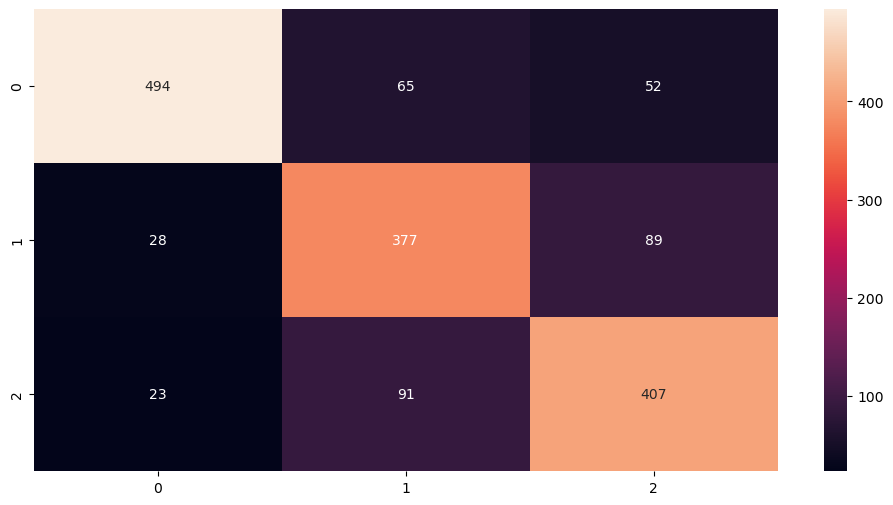

In [24]:
#displaying confusion matrix
print("confusion matrix:")
con_mat = confusion_matrix(validation_labels, y_tes_prd)
print(con_mat)
sns.heatmap(con_mat, annot=True, fmt='d')
plt.show()